In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
# sys.path.append('/beegfs/desy/user/akorol/projects/point-cloud-diffusion/')

/tmp/ipykernel_94485/2900625769.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from utils.plotting import *
from utils.plotting import cfg as cfg_plt

import numpy as np
import h5py
import matplotlib.pyplot as plt

100%|██████████| 30/30 [00:00<00:00, 282.89it/s]


## Calculate num points in the point clouds, and occupancy

In [3]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/10-90GeV_x36_grid_regular.hdf5' # real point clouds
real_showers = h5py.File(path, 'r')['events'][:]

print(len(real_showers))

pos = np.linspace(0, 30, 31)
for i in tqdm(range(30)):
    idx = np.where((real_showers[:, 1] > pos[i]) & (real_showers[:, 1] < pos[i+1]))
    real_showers[:, 1][idx] = layer_bottom_pos[i] + cell_thickness/2

40000


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


In [4]:
# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_10-90GeV_with_flow_corrections_quadratic.npy')
# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_10-90GeV_with_flow_corrections_quadratic_batch.npy') # generated point clouds with CaloClouds

# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_10-90GeV_40k.npy')
#fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_10-90GeV_40k.npy')

# for n hits calibration (n_scaling=False)
# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k.npy')  # seed 1234  # new flow: 220714_cog_e_layer_ShowerFlow_best
# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k.npy')  # seed 1234 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k.npy')  # seed 1234 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
fake_showers[:, -1] = fake_showers[:, -1] / 1000
print(fake_showers.shape)


(40000, 4, 6000)


In [5]:
events = get_projections(real_showers, MAP, layer_bottom_pos)       # get projection of a point clouds to the detector grid
events_fake = get_projections(fake_showers, MAP, layer_bottom_pos)  # get projection of a point clouds to the detector grid

100%|██████████| 40000/40000 [02:26<00:00, 272.19it/s]


In [6]:
_, occ_real, _, _, _, _, _, _ = get_features(events)      # get event level features
_, occ_fake, _, _, _, _, _, _ = get_features(events_fake) # get event level features

100%|██████████| 40000/40000 [02:30<00:00, 264.98it/s]


In [7]:
num_hits_real = (real_showers[:, -1, :] > 0).sum(axis=1)  # get num points in the point clouds
num_hits_fakel = (fake_showers[:, -1, :] > 0).sum(axis=1) # get num points in the point clouds

In [35]:
# np.save('occ_real.npy', occ_real)
# np.save('num_hits_real.npy', num_hits_real)

# np.save('occ_fake.npy', occ_fake)
# np.save('num_hits_fakel.npy', num_hits_fakel)



In [36]:
# occ_real = np.load('occ_real.npy')
# num_hits_real = np.load('num_hits_real.npy')

# occ_fake = np.load('occ_fake.npy')
# num_hits_fakel = np.load('num_hits_fakel.npy')

In [16]:
coef = np.polyfit(num_hits_real, occ_real, 3)
poly1d_fn = np.poly1d(coef)

coef_2 = np.polyfit(num_hits_fakel, occ_fake, 3)
poly1d_fn_2 = np.poly1d(coef_2) 

In [17]:
poly1d_fn   # coef_real

poly1d([ 2.50244046e-09, -2.82685784e-05,  3.15731003e-01,  5.08123555e+01])

In [18]:
poly1d_fn_2   # coef_fake

poly1d([ 4.29894066e-09, -4.61132724e-05,  4.40193379e-01,  6.23006887e+01])

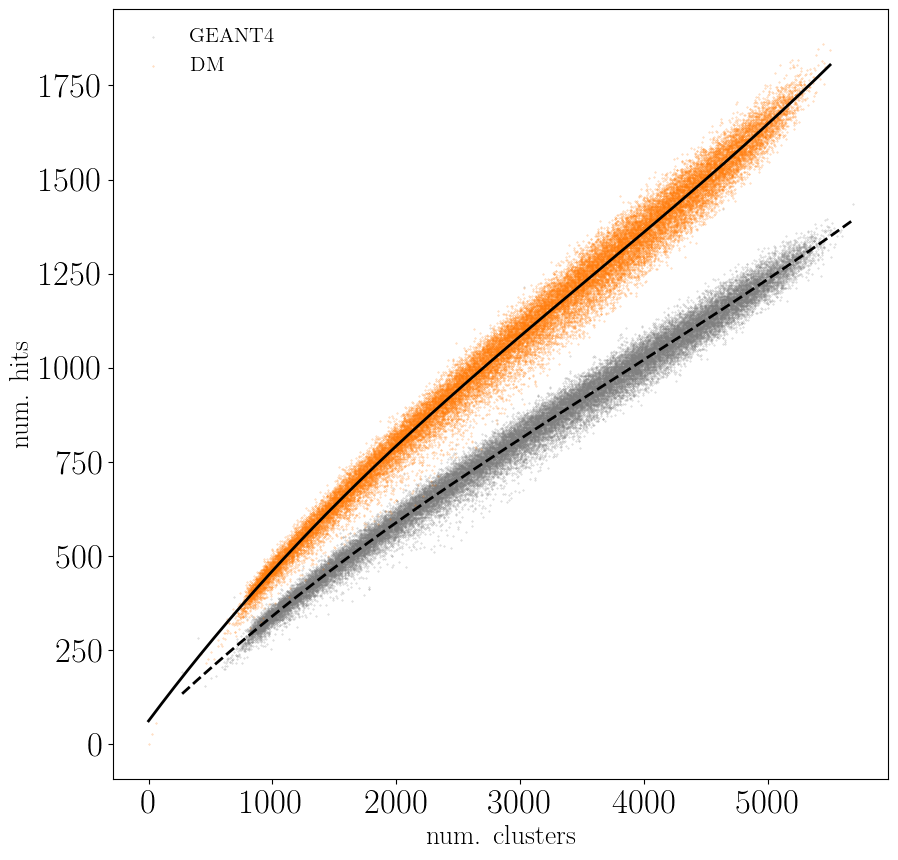

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(num_hits_real, occ_real, s=0.1, alpha=0.5, label='GEANT4', color='grey')
plt.plot(np.arange(num_hits_real.min(), num_hits_real.max()), poly1d_fn(np.arange(num_hits_real.min(), num_hits_real.max())), '--k', lw=2)
plt.scatter(num_hits_fakel, occ_fake, s=0.1, alpha=0.5, label='DM', color='tab:orange')
plt.plot(np.arange(num_hits_fakel.min(), num_hits_fakel.max()), poly1d_fn_2(np.arange(num_hits_fakel.min(), num_hits_fakel.max())), 'k', lw=2)
plt.ylabel('num. hits', fontsize=20, family='serif')
plt.xlabel('num. clusters', fontsize=20, family='serif')
# plt.xlim(150, 1200)
# plt.ylim(400, 3700)
plt.legend(fontsize=15)
plt.show()

In [17]:
def get_scale_factor(num_clusters):
    
    coef_real = np.array([ 2.57988645e-09, -2.94056522e-05,  3.42194568e-01,  5.34968378e+01])
    coef_fake = np.array([ 3.85057207e-09, -4.16463897e-05,  4.19800713e-01,  5.82246858e+01])
    
    poly_fn_real = np.poly1d(coef_real)
    poly_fn_fake = np.poly1d(coef_fake) 
    
    scale_factor = poly_fn_real(num_clusters) / poly_fn_fake(num_clusters)

    return scale_factor

In [18]:
get_scale_factor(np.array([200, 400, 5000]))

array([0.85934084, 0.84574968, 0.84626432])